In [22]:
import os, sys, glob
import numpy as np
from numba import njit
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

from tqdm.notebook import tqdm

from utils import prepare_simulation, prepare_data

In [23]:
source_ra = 77.358 # degrees
source_dec = 5.693 # degrees

ra_bins = np.radians(np.linspace(72, 82, 21))
dec_bins = np.radians(np.linspace(0, 10, 21))

In [24]:
sim = prepare_simulation(source_ra, source_dec, # degrees
                           window = 5, # degrees
                           E0 = 1000, # GeV,
                           gamma = 2,
                           time_mean = 57000,
                           time_sigma = 100,
                           simfile = "/data/mjlarson/datasets/ps_tracks/version-003-p02/IC86_2012_MC.npy")

In [25]:
# And grab the data
data = prepare_data()

# Make your histograms. 

We'll use ra and dec binning here...

In [26]:
# We're going to use np.histogram2d instead of pyplot.hist2d
# since we don't need to look at the plots...
data_hist, _, _ = np.histogram2d(data['ra'], data['dec'],
                                 bins = (ra_bins, dec_bins))
signal_hist, _, _ = np.histogram2d(sim['ra'], sim['dec'],
                                   bins = (ra_bins, dec_bins),
                                   weights=sim['probability_weight'])

bg_hist = np.histogram(data['dec'], bins=dec_bins)[0] 
bg_hist = bg_hist/bg_hist.sum() / (len(ra_bins)-1)
bg_hist = bg_hist[None, :]*np.ones_like(data_hist)

# Something slightly different...

We believe our data histogram $k$ is some combination of the signal histogram $S$ and background histogram $B$ so that

> $k = (\hat{N}_b * B) + (\hat{N}_s * S)$
   
This doesn't give us the full story, however. This just gives us the best 
values for the fit. What we care about is very slightly different, though: 
how much *better* is the fit if we include signal? 

We can get an estimate of the improvement by calculating two $\chi^2$ values 
instead of one. Labeling the expected number of events $\lambda(N_b, N_s)$ 
and the observed data as $k$, 

> $\chi^2(N_b, N_s) = \frac{\left(\lambda(N_b, N_s) - k\right)^2}{\lambda(N_b, N_s)}$

and the $\chi^2$ with no signal is given by 
> $\chi^2(N'_b, N_s=0) = \frac{\left(\lambda(N'_b, N_s=0) - k\right)^2}{\lambda(N'_b, N_s=0)}$

We can then take the difference to see what the improvement in $\chi^2$ is 
from adding signal events to our model.

> $\Delta \chi^2 = \chi^2(N'_b, N_s=0) - \chi^2(N_b, N_s)$

Let's try returning that instead of $N_s$ as our test statistic.

In [27]:
def expectation(N, bg_hist,
                N_s, signal_hist):
    return (N-N_s)*bg_hist + N_s*signal_hist

In [28]:
def chi2(data_hist, 
         N_b, bg_hist, 
         N_s, signal_hist):
    exp_hist = expectation(N_b, bg_hist, 
                           N_s, signal_hist)
    
    with np.errstate(divide='ignore'):
        per_bin_chi2 = ((data_hist-exp_hist)**2 / exp_hist)
        per_bin_chi2[~np.isfinite(per_bin_chi2)] = 0
    return per_bin_chi2.sum()

In [29]:
# And we do the fit using scipy
fit_func = lambda params: chi2(data_hist=data_hist, 
                               N_b=params[0], bg_hist=bg_hist,
                               N_s=params[1], signal_hist=signal_hist)

results_with = minimize(fit_func, 
                        x0 = [data_hist.sum(), 0.0],
                        bounds = [[0.9*data_hist.sum(), 1.1*data_hist.sum()], 
                                  [0, 1000]])

results_without = minimize(fit_func, 
                        x0 = [data_hist.sum(), 0.0],
                        bounds = [[0.9*data_hist.sum(), 1.1*data_hist.sum()], 
                                  [0, 0]])

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


# Take a look at the output numbers

We've fit a value now: N_s. Let's take a look at our best fit values out of the `scipy.optimize.minimize` function.

In [30]:
#print(results)
data_bestfit_delta_chi2 = results_without.fun - results_with.fun
data_bestfit_N_s = results_with.x[1]

print(f"Found a best-fit of {data_bestfit_N_s} signal events")
print(f"Final chi2 value: {data_bestfit_delta_chi2}")

Found a best-fit of 0.0 signal events
Final chi2 value: 7.571434711008237


# Is this good?

We found some signal events again and have a new TS. Is this significant? To
find out, we need to go through the same steps as last time, producing a TS
distribution from background trials to compare to our data TS.

In [31]:
def make_bg_trial_hist(N=data_hist.sum(), bg_hist=bg_hist):
    return np.random.poisson(N*bg_hist)

In [32]:
def get_ts_values(data, 
                  bg_hist,
                  signal_hist,
                  bins,
                  n_trials):
    ts_values = []
    for i in tqdm(range(n_trials)):
        trial_hist = make_bg_trial_hist(N=data_hist.sum(), bg_hist=bg_hist)
        fit_func = lambda params: chi2(data_hist=trial_hist, 
                                       N_b=params[0], bg_hist=bg_hist,
                                       N_s=params[1], signal_hist=signal_hist)
        results_with = minimize(fit_func, 
                                x0 = [trial_hist.sum(), 0.0],
                                bounds = [[0.9*trial_hist.sum(), 1.1*trial_hist.sum()], 
                                          [0, 1000]])

        results_without = minimize(fit_func, 
                                x0 = [trial_hist.sum(), 0.0],
                                bounds = [[0.9*trial_hist.sum(), 1.1*trial_hist.sum()], 
                                          [0, 0]])

        ts_values.append(results_without.fun - results_with.fun)
        
    return np.array(ts_values)


In [33]:
bg_trial_ts_values = get_ts_values(data = data, 
                                   bg_hist = bg_hist,
                                   signal_hist = signal_hist,
                                   bins = (ra_bins, dec_bins),
                                   n_trials = 10000)

Our data fit has a pvalue = 5.745e-01
Alternatively, we see 5745.0/10000 background trials more significant than the data.


Text(0, 0.5, 'Number of trials')

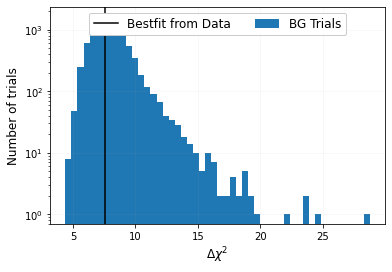

In [34]:
# Print out how rare our best-fit value is in the background distribution!
# This is where we find out how significant our result is!
frac_trials_above_data = (bg_trial_ts_values >= data_bestfit_delta_chi2).sum() / len(bg_trial_ts_values)
print(f"Our data fit has a pvalue = {frac_trials_above_data:4.3e}")
print(f"Alternatively, we see {len(bg_trial_ts_values)*frac_trials_above_data}/{len(bg_trial_ts_values)}"
      " background trials more significant than the data.")

# And plot them along with our original data TS value.
fig, ax = plt.subplots()
_ = ax.hist(bg_trial_ts_values, 
            bins = 50,
            histtype='stepfilled',
            linewidth=3,
            label = 'BG Trials')

# And draw our data TS value.
ax.axvline(data_bestfit_delta_chi2,
           color='k',
           label="Bestfit from Data"
          )

# Make it look nicer.
ax.legend(loc='upper center', ncol=2, fontsize=12, framealpha=1)
ax.grid(alpha=0.1)
ax.set_yscale('log')
ax.set_xlabel(r"$\Delta\chi^2$", fontsize=12)
ax.set_ylabel("Number of trials", fontsize=12)